In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import time
import dwave_token
import dwave
import neal
import dimod
import minorminer
import sklearn.metrics as skm

from dwave.system import DWaveSampler, EmbeddingComposite, AutoEmbeddingComposite, CutOffComposite, FixedEmbeddingComposite, LazyFixedEmbeddingComposite
from dwave.system import DWaveCliqueSampler
from dwave.system import LeapHybridCQMSampler

# DWave_sampler = EmbeddingComposite(DWaveSampler(token=dwave_token.value))
DWave_sampler = AutoEmbeddingComposite(DWaveSampler(token=dwave_token.value))
clique_sampler = DWaveCliqueSampler(token=dwave_token.value)
hybrid_sampler = LeapHybridCQMSampler(token=dwave_token.value)
simulated_sampler = neal.SimulatedAnnealingSampler()
lazy_sampler = LazyFixedEmbeddingComposite(DWaveSampler(token=dwave_token.value))

Matplotlib created a temporary cache directory at /tmp/matplotlib-xb_cn9h4 because the default path (/home/user/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
lazy_embedding_timeout = 60
def make_QUBO_upper_triangle(Q):
    Q = np.array(Q)
    return(np.triu(Q) + np.tril(Q,-1).T)

def cSVM(vectors, labels, upper_bound, kernel=1, solver='CPLEX', time_limit=0, samples=1, adjust_bias=False):
    N = len(vectors)
    d = len(vectors[0])
    if isinstance(kernel, (int, float)): # if a number was given, use gaussian kernel
        kernel = gauss_kernel(kernel)
    if solver == 'hybrid': # see https://docs.ocean.dwavesys.com/en/stable/concepts/cqm.html#id2
        raise TypeError('Real-valued variables are currently not supported in quadratic interactions')
        def sampleset_to_alphas_classical(sampleset, samples):
            filtered_sampleset = sampleset.filter(lambda sample: any(np.array([sample.sample[n] not in [0,upper_bound] for n in range(N)]))) # filter sampleset by found support vectors
            alphas = np.array([list(sample.values()) for sample, in filtered_sampleset.data(fields=['sample'], sorted_by='energy')][:samples])
            objectives = [energy for energy, in filtered_sampleset.data(fields=['energy'], sorted_by='energy')][:samples]
            return(objectives, alphas)
        cqm = dimod.ConstrainedQuadraticModel()
        cqm.add_variables('REAL', N, lower_bound=0, upper_bound=upper_bound)
        cqm.set_objective([(n, m, labels[n]*labels[m]*kernel(vectors[n],vectors[m])) for n in range(N) for m in range(N)] + [(n, -1) for n in range(N)])
        cqm.add_constraint_from_iterable([(n, labels[n]) for n in range(N)], sense='==', rhs=0)
        sampleset = hybrid_sampler.sample_cqm(
            cqm,
            time_limit = time_limit,
        )
        objectives, alphas = sampleset_to_alphas_classical(sampleset, samples)
        fs = [decision_function(vectors, labels, upper_bound, kernel, alpha) for alpha in alphas]
    else:  # use pyomo solver otherwise (CPLEX, Bonmin etc.)
        model = pyo.ConcreteModel()
        model.points = pyo.RangeSet(0,N-1)
        model.dims = pyo.RangeSet(0,d-1)
        #model.x = pyo.Param(model.points, model.dims, within=pyo.Reals, initialize={(p,dim): vectors[p,dim] for p in range(N) for dim in range(d)})
        model.t = pyo.Param(model.points, within={-1,+1}, initialize=labels)
        model.C = pyo.Param(within=pyo.NonNegativeReals, initialize=upper_bound)
        model.kernel_terms = pyo.Param(model.points, model.points, within=pyo.Reals, initialize={(n,m): kernel(vectors[n],vectors[m]) for n in range(N) for m in range(N)})
        model.alpha = pyo.Var(model.points, within=pyo.NonNegativeReals, bounds=(0,model.C))
        model.balance = pyo.Constraint(expr=pyo.summation(model.t,model.alpha) == 0)
        model.obj = pyo.Objective(rule=lambda model: sum(1/2 * sum(model.alpha[n]*model.alpha[m]*model.t[n]*model.t[m]*model.kernel_terms[n,m] for m in model.points) - model.alpha[n] for n in model.points))
        instance = model.create_instance()
        opt = pyo.SolverFactory(solver.lower(), tee=False)
        if time_limit != 0:
            if solver.lower() == 'bonmin': # adapting to the specific solveroptions terminology
                opt.options['bonmin.time_limit'] = time_limit
            else:
                opt.options['timelimit'] = time_limit
        results = opt.solve(instance)
        objectives = [pyo.value(instance.obj)]
        alphas = [np.array([pyo.value(instance.alpha[n]) for n in instance.points])]
        if adjust_bias:
            best_biases = optimize_bias(vectors, labels, upper_bound, kernel, alphas, adjust_bias)
            fs = [decision_function(vectors, labels, upper_bound, kernel, alphas[i], bias=best_biases[i]) for i in range(len(alphas))]
        else:
            fs = [decision_function(vectors, labels, upper_bound, kernel, alphas[0])]
    return(objectives, alphas, fs)

def qSVM(vectors, labels, base, num_encoding, penalty=True, kernel=1, solver='SA', shots=100, time_limit=0, samples=20, adjust_bias=False, embedding=None, print_info=False):
    B = base
    K = num_encoding
    upper_bound = sum(B**k for k in range(K)) # Argument 'upperbound' in cSVM corresponds to sum_{k=0}^{num_encoding-1} base^k
    N = len(vectors)
    d = len(vectors[0])
    if isinstance(kernel, (int, float)): # if a number was given, use gaussian kernel
        kernel = gauss_kernel(kernel)
    if isinstance(penalty, (bool)) and penalty == True:
        1 ### set standard value
    def sampleset_to_alphas(sampleset, samples):
        filtered_sampleset = sampleset.filter(lambda sample: any(np.array([sum(sample.sample[K*n+k] for k in range(K)) not in [0,K] for n in range(N)]))) # filter sampleset by found support vectors
        if len(filtered_sampleset) == 0:
            raise Exception('No support vectors found')
        alphas = np.array([[sum(B**k * sample[K*n+k] for k in range(K)) for n in range(N)] for sample, in filtered_sampleset.data(fields=['sample'], sorted_by='energy')][:samples])
        objectives = [energy for energy, in filtered_sampleset.data(fields=['energy'], sorted_by='energy')][:samples]
        return(objectives, alphas)
        # in the following term I have added a factor 2 in front of the penalty, I think in the paper eq 13 they forgot it
    def QUBO_first_term(penalty):
        return(1/2 * make_QUBO_upper_triangle([[B**(k+j) * labels[n] * labels[m] * (kernel(vectors[n], vectors[m]) + 2*penalty) for m in range(N) for j in range(K)] for n in range(N) for k in range(K)]))
    QUBO_second_term = - np.diag([B**k for n in range(N) for k in range(K)])
    QUBO = QUBO_first_term(penalty) + QUBO_second_term
    bqm = dimod.BinaryQuadraticModel.from_qubo(QUBO)
    if solver == 'hybrid':
        cqm = dimod.ConstrainedQuadraticModel.from_bqm(bqm)
        if isinstance(penalty, (bool)) and penalty == False:
            cqm.add_constraint_from_iterable([(K*n + k, B**k * labels[n]) for n in range(N) for k in range(K)], sense='==', rhs=0)
        sampleset = hybrid_sampler.sample_cqm(
            cqm,
            time_limit = time_limit,
        )
    else:
        if solver == 'clique':
            sampler = clique_sampler
        elif solver == 'SA':
            sampler = simulated_sampler
        elif isinstance(solver, (int, float)): # if sampler is a number, it is interpreted as the relative desired increase in zeros in the QUBO. 1 would mean that all non-linear terms are 0
            cutoff, initial_relative_zeros, new_QUBO = calculate_cut_off(QUBO, solver, max_non_zeros=35000)
            non_zeros = np.count_nonzero(new_QUBO - np.diag(np.diag(new_QUBO)))
            if print_info:
                print('Initial_relative_zeros: ', initial_relative_zeros)
                print('cutoff: ', cutoff)
                print('Non-zero connections: ', non_zeros)
            ###
            if embedding == 'save' or type(embedding) == dwave.embedding.transforms.EmbeddedStructure:
                sampler = lazy_sampler
                sampler.find_embedding = lambda S, T: minorminer.find_embedding(S, T, timeout=lazy_embedding_timeout)
                bqm = dimod.BinaryQuadraticModel.from_qubo(new_QUBO)
            else:
                sampler = CutOffComposite(DWave_sampler, cutoff)
        elif embedding == 'save' or solver == 'lazy' or solver == 'save_embedding' or type(embedding) == dwave.embedding.transforms.EmbeddedStructure:
            sampler = lazy_sampler
            sampler.find_embedding = lambda S, T: minorminer.find_embedding(S, T, timeout=lazy_embedding_timeout)
        else:
            sampler = DWave_sampler
        if type(embedding) == dwave.embedding.transforms.EmbeddedStructure:
            sampler._fix_embedding(embedding)
        chain_strength = max(bqm.quadratic.values())
        sampleset = sampler.sample(
            bqm,
            num_reads=shots,
            chain_strength=chain_strength
        )
    sampleset.resolve() # to reduce output readout time
    if embedding == 'save' or solver == 'save_embedding' or type(embedding) == dwave.embedding.transforms.EmbeddedStructure:
        embedding = sampler.embedding
    else:
        embedding = None
    objectives, alphas = sampleset_to_alphas(sampleset, samples)
    if adjust_bias: # for this we assume that the kernel is allowed to take arrays in its first argument
        a = time.time()
        best_biases = optimize_bias(vectors, labels, upper_bound, kernel, alphas, adjust_bias, print_info)
        fs = [decision_function(vectors, labels, upper_bound, kernel, alphas[i], bias=best_biases[i]) for i in range(len(alphas))]
        if print_info:
            print('bias adjustment time: ', time.time()-a)
    else:
        fs = [decision_function(vectors, labels, upper_bound, kernel, alpha) for alpha in alphas]
    return(objectives, alphas, fs, embedding)

def calculate_cut_off(QUBO, relative_zero_improvement, max_non_zeros=35000):
    # this function calculates the cutoff value of connections (quadratic values) of a QUBO, based on how large of a portion shall be set to zero. 
    # max_non_zeros serves as an absolute value of how many connections can be non zero at most
    # relative_zero_improvement adds to the portion which shall be zero
    N = (len(QUBO)**2 - len(QUBO)) / 2
    QUBO = make_QUBO_upper_triangle(QUBO)
    QUBO_connections = QUBO[np.triu_indices(len(QUBO),1)]
    non_zero_QUBO_connections = QUBO_connections[QUBO_connections != 0]
    values = sorted(set(np.round(abs(non_zero_QUBO_connections),4)))
    num_entries_smaller_than_values = np.array([np.count_nonzero(abs(non_zero_QUBO_connections) <= value) for value in values])
    forced_zeros = min(len(non_zero_QUBO_connections), max(len(non_zero_QUBO_connections) - max_non_zeros,0) + relative_zero_improvement*N)
    cutoff = next((value for i, value in enumerate(values) if num_entries_smaller_than_values[i] >= forced_zeros), 0)
    initial_relative_zeros = 1 - len(non_zero_QUBO_connections)/N
    new_QUBO = QUBO * (abs(QUBO) > cutoff)
    return(cutoff, initial_relative_zeros, new_QUBO)
    
def optimize_bias(vectors, labels, upper_bound, kernel, alphas, metric, print_info=False):
    N = len(vectors)
    fs = [decision_function(vectors, labels, upper_bound, kernel, alpha, bias=0) for alpha in alphas]
    f_values_lists = [np.unique(f(vectors), return_index=True) for f in fs] # sorted lists of all function values without dublicates
    bias_filters =  [[j for j in range(len(f_values_lists[i][0])-1) if labels[f_values_lists[i][1][j+1]] == 1 and (labels[f_values_lists[i][1][j]] == -1 or j == 0)] for i in range(len(fs))]
    potential_bias_lists = [[standard_bias(vectors, labels, upper_bound, kernel, alphas[i])] + [- np.mean(f_values_lists[i][0][j:j+2]) for j in bias_filters[i]] for i in range(len(fs))] # lists of possible bias choices (standard bias + half way between function values)
    if metric == 'kappa':
        accuracy_lists = [[kappa(decision_function(vectors, labels, upper_bound, kernel, alphas[i], bias=b), vectors, labels) for b in potential_bias_lists[i]] for i in range(len(fs))]
    else:
        accuracy_lists = [[np.sum(np.sign(decision_function(vectors, labels, upper_bound, kernel, alphas[i], bias=b)(vectors)) == labels) for b in potential_bias_lists[i]] for i in range(len(fs))]
    best_biases = [potential_bias_lists[i][max(enumerate(accuracy_lists[i]), key=lambda x: x[1])[0]] for i in range(len(fs))]
    if print_info:
        print('New bias: ', best_biases[0], ' Standard bias: ', standard_bias(vectors, labels, upper_bound, kernel, alphas[0]))
    return(best_biases)

def standard_bias(vectors, labels, upper_bound, kernel, alpha):
    # assumes that kernel accepts arrays in its first argument
    # will give out an array of biases if an array of alphas is provided
    labels = np.array(labels)
    N = len(vectors)
    C = upper_bound
    if len(np.shape(alpha)) == 1:
        b = np.einsum('i,i,i', alpha, C - alpha, labels - np.dot(kernel(vectors, vectors), alpha * labels)) / np.dot(alpha, C - alpha)
    else:
        b = np.einsum('fi,fi,fi->f', alpha, C - alpha, labels - np.einsum('ij,fj,j->fi', kernel(vectors, vectors), alpha, labels)) / np.einsum('fi,fi->f', alpha, C - alpha)
    return(b)

def decision_function(vectors, labels, upper_bound, kernel, alpha, bias=None):
    # the kernel is assumed to accept arrays in its first argument
    N = len(vectors)
    if bias == None: # standard bias:
        b = standard_bias(vectors, labels, upper_bound, kernel, alpha)
    else: # custom bias:
        b = bias
    def f(vector):
        if len(np.shape(vector)) == 1:
            return(np.einsum('i,i,i', alpha, labels, kernel(vectors, vector)) + b)
        else:
            return(np.einsum('i,i,ji->j', alpha, labels, kernel(vectors, np.array(vector))) + b)
    return(f)

def averaged_decision_function_from_samples(vectors, labels, upper_bound, kernel, alphas, biases=None):
    # the kernel is assumed to accept arrays in its first argument
    N = len(vectors)
    if biases == None: # standard bias:
        b = np.mean(standard_bias(vectors, labels, upper_bound, kernel, alphas))
    else: # custom bias:
        b = np.mean(biases)
    alpha = np.mean(alphas, axis=0)
    def f(vector):
        if len(np.shape(vector)) == 1:
            return(np.einsum('i,i,i', alpha, labels, kernel(vectors, vector)) + b)
        else:
            return(np.einsum('i,i,ji->j', alpha, labels, kernel(vectors, np.array(vector))) + b)
    return(f)

def averaged_decision_function(fs):
    def averaged_f(vector):
        average = np.mean([f(vector) for f in fs], axis=0)
        return(average)
    return(averaged_f)

def gauss_kernel(gamma):
    def kernel(x,y):
        if len(np.shape(x)) == 1:
            length_squared = np.dot(x-y,x-y)
        elif len(np.shape(y)) == 1: # allows arrays in first argument, this will return arrays
            length_squared = np.einsum('ij,ij->i',x-y,x-y)
        else: # allows also arrays in second argument, this will return a 2-array
            x_new = np.repeat(x[np.newaxis, :, :],len(y), axis=0)
            y_new = np.repeat(y[:, np.newaxis, :],len(x), axis=1)
            length_squared = np.einsum('ijk,ijk->ij',x_new-y_new,x_new-y_new)
        return(np.exp(-gamma * length_squared))
    return(kernel)
def polynomial_kernel(d,c=0, gamma=1):
    def kernel(x,y): # also allows first argument to be arrays and second too if the first one is
        return((gamma*np.dot(y,x.T) + c)**d)
    return(kernel)
def linear_kernel(gamma):
    return(polynomial_kernel(1, 0, gamma))

# prepare data:

def read_compounds(file_name, names_first=True, skip_parameters=0):
    scan = np.genfromtxt(file_name, delimiter=";")
    rows = len(scan)-1
    cols = len(scan[0])
    matrix = np.genfromtxt(file_name, delimiter=";", skip_header=1, usecols=range(1 + int(names_first) + skip_parameters, cols))
    if names_first:
        names = np.genfromtxt(file_name, delimiter=";", skip_header=1, usecols=0, dtype="S")
    else: names = np.array(['Compound ' + str(i) for i in range(rows)])
    classes = np.genfromtxt(file_name, delimiter=";", skip_header=1, usecols=int(names_first), dtype="S") 
    labels = [+1 if (s==b'"Approved"' or s==b'1') else -1 if (s==b'"Withdrawn"' or s==b'0' or s==b'-1') else 0 for s in classes]
    return(rows, matrix, names, labels)

def prepare_data_sets(vectors, labels, test_training_ratio=5, approved_slice_ratio=1, withdrawn_slice_ratio=1):
    m = len(vectors)
    # remove degenerate vectors with inconsistent labels:
    uniques, counts = np.unique(vectors, axis=0, return_counts=True)
    degeneracies = uniques[counts>1]
    for vector in degeneracies:
        deg_indices = list(np.where(np.all(vectors == vector, axis=1))[0])
        deg_labels = np.array(labels)[deg_indices]
        if not np.all(np.full(np.shape(deg_labels), deg_labels[0]) == deg_labels):
            for i in deg_indices[::-1]:
                vectors = np.delete(vectors, (i), axis=0)
                labels = np.delete(labels, (i))
    print('{} vectors removed due to inconsistently labelled degeneracies'.format(m - len(vectors)))
    # leave only every approved_slice_ratio-th approved compound and withdrawn_slice_ratio-th withdrawn compound
    for i, label in sorted(enumerate(labels), reverse=True):
        if not label in [-1,+1] or (label == 1 and i % approved_slice_ratio != 0) or (label == -1 and i % withdrawn_slice_ratio != 0):
            vectors = np.delete(vectors, (i), axis=0)
            labels = np.delete(labels, (i))
    # prepare training and test sets
    test_vectors, test_labels = np.empty(shape=(0, len(vectors[0]))),[]
    for i, label in sorted(enumerate(labels), reverse=True):
        if i % test_training_ratio == 0:
            test_vectors = np.insert([vectors[i]], 1, test_vectors, axis=0)
            test_labels = np.append(label, test_labels)
            vectors = np.delete(vectors, (i), axis=0)
            labels = np.delete(labels, (i))
    return(vectors, labels, test_vectors, test_labels)

def slice_training_data(training_vectors, training_labels, slice_size, max_centroid_iteration=1, random_type='normal', centroid_distance_optimization='min', print_info=False):
    ## only works for data of dimension > 1
    ## this function assumes that we have a positive bias in the data
    d = len(training_vectors[0])
    pos_vectors = np.array([vector for vector, label in zip(training_vectors, training_labels) if label == 1])
    neg_vectors = np.array([vector for vector, label in zip(training_vectors, training_labels) if label == -1])
    neg_overall_centroid = np.mean(neg_vectors, axis=0)
    # add label info such we keep that information while shuffeling
    # distribute positive vectors:
    num_slices = round(2*len(pos_vectors)/slice_size)
    num_positive_per_slice = len(pos_vectors) // num_slices * np.ones(num_slices, dtype=int) + np.append(np.ones(len(pos_vectors) % num_slices, dtype=int), np.zeros(num_slices - len(pos_vectors) % num_slices, dtype=int))
    np.random.shuffle(pos_vectors)
    slices = [np.append(pos_vectors[int(np.sum(num_positive_per_slice[:i])):int(np.sum(num_positive_per_slice[:i]) + num_positive)], np.zeros((int(slice_size - num_positive),d)), axis=0) for i, num_positive in enumerate(num_positive_per_slice)]
    # complement with random instances of neg_vectors:
    if random_type == 'equal':
        for l in range(int(np.sqrt(max_centroid_iteration))):
            distribution = distribute_items_equally(range(len(neg_vectors)), slice_size - num_positive_per_slice) # try use (almost) equally many negative vectors
            length_sorted_subdistributions = {length: [candidates for candidates in distribution if len(candidates) == length] for length in {len(candidates) for candidates in distribution}}
            if l == 0:
                best_candidates = [neg_vectors[distribution[i]] for i in range(num_slices)]
                opt_mean_distance = np.mean([np.linalg.norm(np.mean(slices[i][:num_positive], axis=0) - np.mean(best_candidates[i], axis=0)) for i, num_positive in enumerate(num_positive_per_slice)])
            for j in range(int(np.sqrt(max_centroid_iteration))-1): # reshuffle the distributions of negative vectors
                for length in length_sorted_subdistributions.keys():
                    np.random.shuffle(length_sorted_subdistributions[length])
                distribution = [candidates for subdistributions in length_sorted_subdistributions.values() for candidates in subdistributions]
                candidates = [neg_vectors[distribution[i]] for i, num_positive in enumerate(num_positive_per_slice)]
                mean_distance = np.mean([np.linalg.norm(np.mean(slices[i][:num_positive], axis=0) - np.mean(candidates[i], axis=0)) for i, num_positive in enumerate(num_positive_per_slice)])
                if (mean_distance if centroid_distance_optimization == 'min' else opt_mean_distance) < (opt_mean_distance  if centroid_distance_optimization == 'min' else mean_distance):
                    best_candidates = candidates
                    opt_mean_distance = mean_distance
            for i, num_positive in enumerate(num_positive_per_slice):
                slices[i][num_positive:] = best_candidates[i]
    else:
        for i, num_positive in enumerate(num_positive_per_slice):
            pos_centroid = np.mean(slices[i][:num_positive], axis=0)
            opt_distance = (np.sqrt(d) if centroid_distance_optimization == 'min' else 0) if max_centroid_iteration < 10 else np.linalg.norm(pos_centroid - neg_overall_centroid)
            # choose a negative group whose centroid is close to the one of the positive group
            for j in range(max_centroid_iteration):
                neg_slice_candidate = neg_vectors[np.random.choice(len(neg_vectors), int(slice_size - num_positive), replace=False)]
                neg_centroid = np.mean(neg_slice_candidate, axis=0)
                distance = np.linalg.norm(pos_centroid - neg_centroid)
                if (distance if centroid_distance_optimization == 'min' else opt_distance) < (opt_distance  if centroid_distance_optimization == 'min' else distance):
                    opt_distance = distance
                    best_candidate = neg_slice_candidate
            slices[i][num_positive:] = best_candidate
    # extract labels
    slice_labels = np.array([np.append(np.ones(num_positive), -np.ones(slice_size - num_positive)) for num_positive in num_positive_per_slice])
    # info about negative slice distribution:
    counts = [np.count_nonzero([np.any(np.all(slice == vector, axis=1)) for j, slice in enumerate(slices)]) for i, vector in enumerate(neg_vectors)]
    mean_distance = np.mean([np.linalg.norm(np.mean(slices[i][:num_positive], axis=0) - np.mean(slices[i][num_positive:], axis=0)) for i, num_positive in enumerate(num_positive_per_slice)])
    if print_info:
        print('average distance of centroids: ', mean_distance)
        print('Variance in negative vector appearences: ', np.var(counts))
    return(slices, slice_labels, counts, mean_distance)

# plots:

def plot_compounds(matrix, labels, f, highlight=[], highlight_text='', marker_size=20, aspect_ratio=None, save=False):
    M = len(matrix)
    x = range(M)
    y = f(matrix)
    if highlight:
        normal = np.setdiff1d(x, highlight)
        y_highlighted = np.array(y)[highlight]
        y_normal = np.array(y)[normal]
        plt.scatter(normal,y_normal, s=marker_size, c=['blue' if labels[i]==+1 else 'red' if labels[i]==-1 else 'grey' for i in normal], marker='o')
        plt.scatter(highlight,y_highlighted, s=marker_size, c=['blue' if labels[i]==+1 else 'red' if labels[i]==-1 else 'grey' for i in highlight], marker='x', label=highlight_text)
        plt.legend()
    else:
        plt.scatter(x,y, s=marker_size, c=['blue' if labels[i]==+1 else 'red' if labels[i]==-1 else 'grey' for i in range(M)])
    ax = plt.gca()
    ax.axhline(y=0, c='gray', alpha=0.5, linestyle='--') # origin axis line
    plt.ylabel('f')
    if isinstance(aspect_ratio, (int, float)):
        ax.set_aspect(abs((ax.get_xlim()[0] - ax.get_xlim()[1])/(ax.get_ylim()[0]-ax.get_ylim()[1]))*aspect_ratio)
    if save:
        if not isinstance(save, (str)): # standard name
            save = 'plot'
        plt.savefig(save + '.png' ,dpi=300)
    plt.show()

def boxplot_compounds(matrix, labels, f, save=False):
    plt.boxplot(x=[
        f([vector for i, vector in enumerate(matrix) if labels[i] == +1]), # approved
        f([vector for i, vector in enumerate(matrix) if labels[i] == -1]), # withdrawn
        f([vector for i, vector in enumerate(matrix) if labels[i] == 0]) if len([vector for i, vector in enumerate(matrix) if labels[i] == 0]) > 0 else [], # preclinical
    ])
    ax = plt.gca()
    ax.axhline(y=0, c='gray', alpha=0.5, linestyle='--') # origin axis line
    ax.set_xticks(range(1,4), [
        'approved',
        'withdrawn',
        'preclinical',
    ], fontsize=7)
    if save:
        if not isinstance(save, (str)): # standard name
            save = 'plot'
        plt.savefig(save + '.png' ,dpi=300)
    plt.show()

def boxplot_compounds2(matrix, labels, functions, function_labels=['qSVM', 'cSVM'], save=False):
    fig, ax = plt.subplots(1,2)
    for j in range(2):
        ax[j].boxplot(x=[
            [functions[j](vector) for i, vector in enumerate(matrix) if labels[i] == +1], # approved
            [functions[j](vector) for i, vector in enumerate(matrix) if labels[i] == -1], # withdrawn
            [functions[j](vector) for i, vector in enumerate(matrix) if labels[i] == 0], # preclinical
        ])
        ax[j].axhline(y=0, c='gray', alpha=0.5, linestyle='--') # origin axis line
        ax[j].set_box_aspect(0.7)
        ax[j].set_xticks(range(1,4), [
            'approved',
            'withdrawn',
            'preclinical',
        ], fontsize=7)
        ax[j].title.set_text(function_labels[j])
    if save:
        if not isinstance(save, (str)): # standard name
            save = 'plot'
        plt.savefig(save + '.png' ,dpi=300)
    plt.show()

def plot_curve(x, y, xlabel, ylabel, save=False):
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if save:
        if not isinstance(save, (str)): # standard name
            save = 'plot'
        plt.savefig(save + '.png' ,dpi=300)
    plt.show()

# evaluation metrics:

def kappa(f, test_vectors, test_labels):
    predicted_labels = np.sign(f(test_vectors))
    kappa_score = skm.cohen_kappa_score(test_labels, predicted_labels)
    return(kappa_score)
def accuracy(f, test_vectors, test_labels):
    predicted_labels = np.sign(f(test_vectors))
    accuracy_score = skm.accuracy_score(test_labels, predicted_labels)
    return(accuracy_score)
def AUROC(f, test_vectors, test_labels, plot=False):
    function_values = f(test_vectors)
    auroc = skm.roc_auc_score(test_labels, function_values)
    if plot:
        false_positive_rate, true_positive_rate = ROC_curve(f, test_vectors, test_labels)
        plot_curve(false_positive_rate, true_positive_rate, 'False Positive Rate', 'True Positive Rate')
    return(auroc)
def AUPRC(f, test_vectors, test_labels, plot=False):
    precision, recall = PR_curve(f, test_vectors, test_labels)
    auprc = skm.auc(recall, precision)
    # auprc = np.trapz(precision, recall) # this seems to yield the same but is faster
    if plot:
        plot_curve(recall, precision, 'Recall', 'Precision')
    return(auprc)
def ROC_curve(f, test_vectors, test_labels):
    function_values = f(test_vectors)
    false_positive_rate, true_positive_rate, _ = skm.roc_curve(test_labels, function_values)
    return(false_positive_rate, true_positive_rate)
def PR_curve(f, test_vectors, test_labels):
    function_values = f(test_vectors)
    precision, recall, _ = skm.precision_recall_curve(test_labels, function_values)
    return(precision[::-1], recall[::-1])

def print_measures(f, test_vectors, test_labels, title=None):
    print(title)
    print('Kappa score = ', kappa(f, test_vectors, test_labels))
    print('Accuracy score = ', accuracy(f, test_vectors, test_labels))
    print('AUROC = ', AUROC(f, test_vectors, test_labels))
    print('AUPRC = ', AUPRC(f, test_vectors, test_labels))

# further functions:
def distribute_items_equally(items, bin_sizes):
    # distríbutes a 1d set of items (almost) equally on bins of fixed size
    if len(np.shape(items)) > 1:
        raise Exception('Please use a 1d array of items')
    min_count_of_items = sum(bin_sizes) // len(items)
    while True:
        bins = [[] for _ in range(len(bin_sizes))]
        non_filled_bins = list(range(len(bin_sizes)))
        try:
            for item in items:
                random_choice = np.random.choice(non_filled_bins, min_count_of_items - 1, replace=False)
                for bin in random_choice:
                    bins[bin] += [item]
                # include most empty bin:
                max_emptiness = max([bin_sizes[bin] - len(bins[bin]) for bin in non_filled_bins if bin not in random_choice])
                if max_emptiness > 0:
                    most_empty_bins = np.setdiff1d(np.where([bin_sizes[i] - len(bin) == max_emptiness for i, bin in enumerate(bins)])[0], random_choice)
                    chosen_most_empty_bin = np.random.choice(most_empty_bins, 1)[0]
                    bins[chosen_most_empty_bin] += [item]
                non_filled_bins = [i for i, bin in enumerate(bins) if len(bin) < bin_sizes[i]]
            # fill up remaining bins:
            for i, bin in enumerate(bins):
                if i in non_filled_bins:
                    random_itmes_to_add = np.random.choice([item for item in items if not item in bin], bin_sizes[i] - len(bin), replace=False)
                    bins[i] = np.append(bin, random_itmes_to_add)
            non_filled_bins = [i for i, bin in enumerate(bins) if len(bin) < bin_sizes[i]]
            if not non_filled_bins:
                break
            else:
                continue # try again
        except ValueError:
            continue # try again
    return(bins)

Quantum SVM tests:

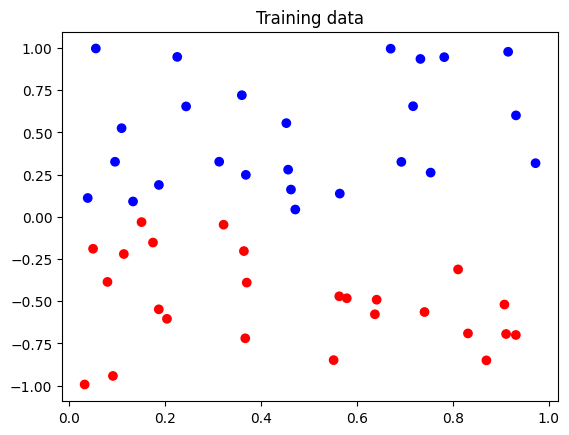

In [19]:
N = 50
vectors = np.transpose([np.random.rand(N), 2*np.random.rand(N)-1])
labels = [2*int(y>0)-1 for x,y in vectors]
x, y = np.transpose(vectors)
plt.scatter(x,y, c=['blue' if labels[i] > 0 else 'red' for i in range(N)])
plt.title('Training data')
plt.show()

base = 2
num_encoding = 4
penalty = 3
kernel = gauss_kernel(1)

# objectives, alphas, fs = qSVM(vectors, labels, base=base, num_encoding=num_encoding, penalty=penalty, kernel=kernel, solver='SA', shots=100, time_limit=0, samples=20, adjust_bias=True)
# f = fs[0]
# print('SA best objective: ', objectives[0])
# objectives2, alphas2, gs = qSVM(vectors, labels, base=base, num_encoding=num_encoding, penalty=penalty, kernel=kernel, solver='clique', shots=100, time_limit=0, samples=20, adjust_bias=True)
# g = gs[0]
# print('Clique best objective: ', objectives2[0])
# objectives3, alphas3, hs = qSVM(vectors, labels, base=base, num_encoding=num_encoding, penalty=penalty, kernel=kernel, solver='sampler', shots=100, time_limit=0, samples=20, adjust_bias=True)
# h = hs[0]
# print('DWaveSampler best objective: ', objectives3[0])

In [20]:
objectives, alphas, fs, _ = qSVM(vectors, labels, base=base, num_encoding=num_encoding, penalty=penalty, kernel=kernel, solver='SA', shots=100, time_limit=0, samples=20, adjust_bias=True)
f = fs[0]

New bias:  0.13616517879908052  Standard bias:  0.5146540500945868
bias adjustment time:  0.006371259689331055


In [21]:
objectives2, alphas2, gs, _ = qSVM(vectors, labels, base=base, num_encoding=num_encoding, penalty=penalty, kernel=kernel, solver='clique', shots=100, time_limit=0, samples=20, adjust_bias=True)
g = gs[0]

ValueError: Cannot embed given BQM (size 200), sampler can only handle problems of size 177

In [22]:
objectives3, alphas3, hs, _ = qSVM(vectors, labels, base=base, num_encoding=num_encoding, penalty=penalty, kernel=kernel, solver='sampler', shots=100, time_limit=0, samples=20, adjust_bias=True)
h = hs[0]

ValueError: no embedding found

In [23]:
objectives4, alphas4, ks, _ = qSVM(vectors, labels, base=base, num_encoding=num_encoding, penalty=penalty, kernel=kernel, solver=0.2, shots=100, time_limit=0, samples=20, adjust_bias=True)
k = ks[0]

Initial_relative_zeros:  0.0
New bias:  5.321662625430938  Standard bias:  5.321662625430938
bias adjustment time:  0.006364107131958008


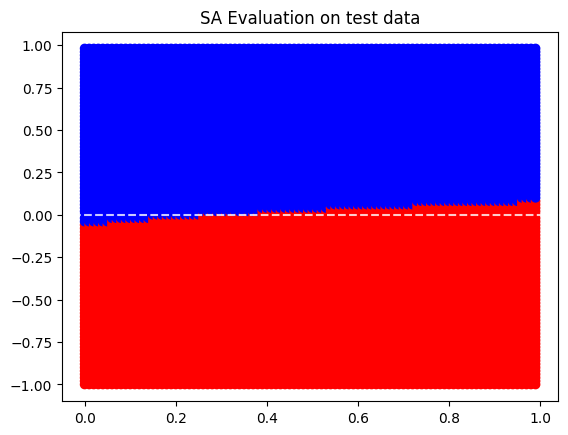

SA
Kappa score =  0.9629717103867355
Accuracy score =  0.9815
AUROC =  0.9993353341336534
AUPRC =  0.999308409732607


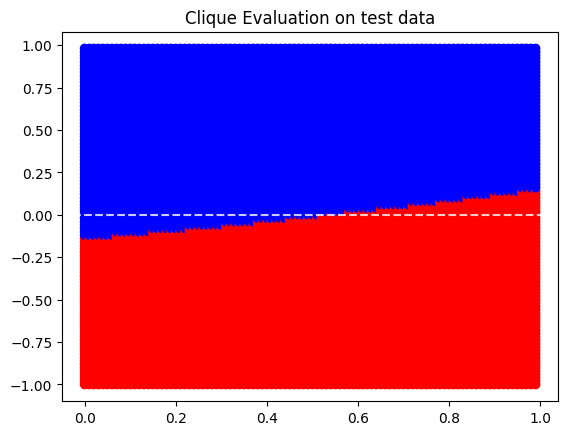

Clique
Kappa score =  0.9263864551077399
Accuracy score =  0.9632
AUROC =  0.9965562224889956
AUPRC =  0.996481780438837


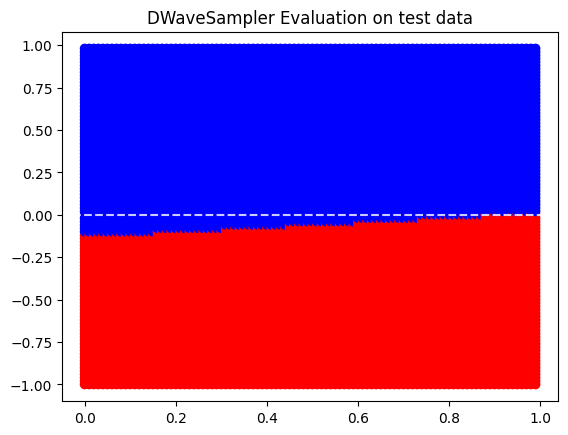

DWaveSampler
Kappa score =  0.937253710823535
Accuracy score =  0.9686
AUROC =  0.9992678271308524
AUPRC =  0.9992518443431029


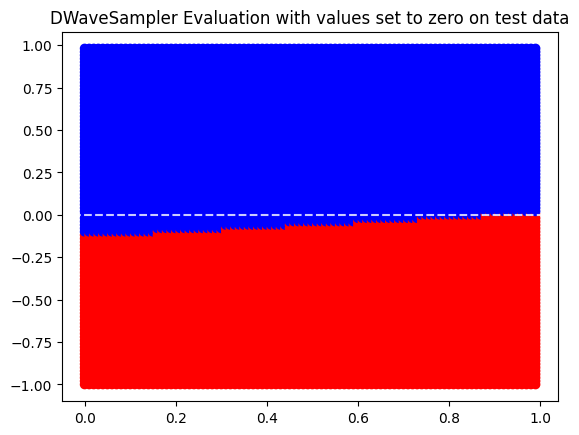

DWaveSampler with values set to zero
Kappa score =  0.937253710823535
Accuracy score =  0.9686
AUROC =  0.9992678271308524
AUPRC =  0.9992518443431029


In [26]:
M = 100
x, y = (np.array([[i]*M for i in range(M)])/M).flatten(), 2*np.array(list(range(M))*M)/M - 1
test_vectors = [(x[i],y[i]) for i in range(len(x))]
test_labels = [2*int(y[i]>0)-1 for i in range(len(x))]

plt.scatter(x,y, c=['blue' if f((x[i],y[i])) > 0 else 'red' if f((x[i],y[i])) < 0 else 'black 'for i in range(M*M)])
plt.title('SA Evaluation on test data')
ax = plt.gca()
ax.axhline(y=0, c='white', alpha=0.8, linestyle='--') # origin axis line
plt.show()
print_measures(f, test_vectors, test_labels, 'SA')

plt.scatter(x,y, c=['blue' if g((x[i],y[i])) > 0 else 'red' if g((x[i],y[i])) < 0 else 'black 'for i in range(M*M)])
plt.title('Clique Evaluation on test data')
ax = plt.gca()
ax.axhline(y=0, c='white', alpha=0.8, linestyle='--') # origin axis line
plt.show()
print_measures(g, test_vectors, test_labels, 'Clique')

plt.scatter(x,y, c=['blue' if h((x[i],y[i])) > 0 else 'red' if h((x[i],y[i])) < 0 else 'black 'for i in range(M*M)])
plt.title('DWaveSampler Evaluation on test data')
ax = plt.gca()
ax.axhline(y=0, c='white', alpha=0.8, linestyle='--') # origin axis line
plt.show()
print_measures(h, test_vectors, test_labels, 'DWaveSampler')

plt.scatter(x,y, c=['blue' if h((x[i],y[i])) > 0 else 'red' if h((x[i],y[i])) < 0 else 'black 'for i in range(M*M)])
plt.title('DWaveSampler Evaluation with values set to zero on test data')
ax = plt.gca()
ax.axhline(y=0, c='white', alpha=0.8, linestyle='--') # origin axis line
plt.show()
print_measures(h, test_vectors, test_labels, 'DWaveSampler with values set to zero')

Compound data:

In [5]:
folder = 'Compound data/'
file_name = 'original_descriptors_normalized_min_max_training_alternating.csv'
path  = os.path.join(folder,file_name)
rows, matrix, names, labels = read_compounds(path)
vectors, labels, test_vectors, test_labels = prepare_data_sets(matrix, labels, test_training_ratio=5, approved_slice_ratio=1, withdrawn_slice_ratio=1)

base = 3
num_encoding = 3
penalty = 3
kernel = gauss_kernel(1)

# train SVMs, plot resulting classifier for training data
objectives, alphas, fs, _ = qSVM(vectors, labels, base=base, num_encoding=num_encoding, penalty=penalty, kernel=kernel, solver='SA', shots=100, time_limit=5, samples=20, adjust_bias=True)
plot_compounds(vectors, labels, fs[0])
print('SA objective: ', objectives[0])

objectives2, alphas2, gs, _ = qSVM(vectors, labels, base=base, num_encoding=num_encoding, penalty=penalty, kernel=kernel, solver='clique', shots=100, time_limit=5, samples=20, adjust_bias=True)
plot_compounds(vectors, labels, gs[0])
print('Clique objective: ', objectives2[0])

objectives3, alphas3, hs, _ = qSVM(vectors, labels, base=base, num_encoding=num_encoding, penalty=penalty, kernel=kernel, solver='dwave', shots=100, time_limit=5, samples=20, adjust_bias=True)
plot_compounds(vectors, labels, hs[0])
print('DWave objective: ', objectives3[0])

New bias:  -1.1392733263880783  Standard bias:  -1.1392733263880783
bias adjustment time:  0.012285709381103516


ValueError: too many values to unpack (expected 3)

In [11]:
print('SA:')
print_measures(fs[0], test_vectors, test_labels)
plot_compounds(test_vectors, test_labels, fs[0])
print('Clique:')
print_measures(gs[0], test_vectors, test_labels)
plot_compounds(test_vectors, test_labels, gs[0])
print('DWave:')
print_measures(hs[0], test_vectors, test_labels)
plot_compounds(test_vectors, test_labels, hs[0])

Larger Data instances:

In [6]:
folder = 'Compound data/'
file_name = 'database_319_105feature_normalized_v2.csv'
path  = os.path.join(folder,file_name)
rows, matrix, names, labels = read_compounds(path, names_first=False)
vectors, labels, test_vectors, test_labels = prepare_data_sets(matrix, labels, test_training_ratio=5, approved_slice_ratio=2, withdrawn_slice_ratio=8)

base = 3
num_encoding = 3
penalty = 7
kernel = gauss_kernel(1)

# train SVMs, plot resulting classifier for training data
# objectives, alphas, fs = qSVM(vectors, labels, base=base, num_encoding=num_encoding, penalty=penalty, kernel=kernel, solver='SA', shots=100, time_limit=5, samples=20, adjust_bias=True)
# plot_compounds(vectors, labels, fs[0])
# print('SA objective: ', objectives[0])

# objectives2, alphas2, gs = qSVM(vectors, labels, base=base, num_encoding=num_encoding, penalty=penalty, kernel=kernel, solver='clique', shots=100, time_limit=5, samples=20, adjust_bias=True)
# plot_compounds(vectors, labels, gs[0])
# print('Clique objective: ', objectives2[0])

# objectives3, alphas3, hs = qSVM(vectors, labels, base=base, num_encoding=num_encoding, penalty=penalty, kernel=kernel, solver='dwave', shots=100, time_limit=5, samples=20, adjust_bias=True)
# plot_compounds(vectors, labels, hs[0])
# print('DWave objective: ', objectives3[0])

New bias:  -1.039924315835603  Standard bias:  -0.4205097047496013
bias adjustment time:  0.06742572784423828


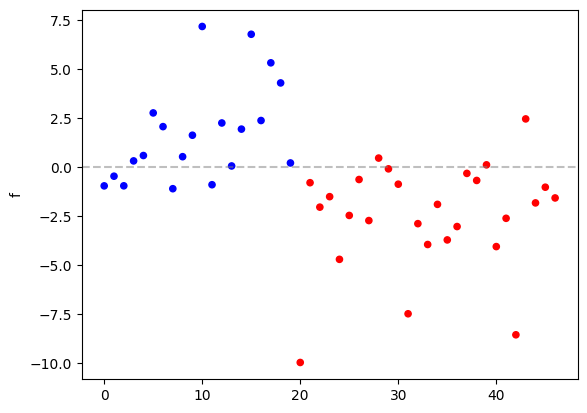

SA objective:  158.63187774501057


In [7]:
objectives, alphas, fs, _ = qSVM(vectors, labels, base=base, num_encoding=num_encoding, penalty=penalty, kernel=kernel, solver='SA', shots=100, time_limit=5, samples=20, adjust_bias=True)
plot_compounds(vectors, labels, fs[0])
print('SA objective: ', objectives[0])

New bias:  -0.16070145867557567  Standard bias:  0.04598920694398857
bias adjustment time:  0.05382728576660156


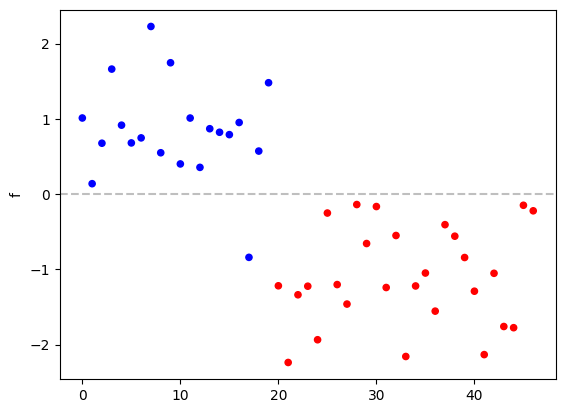

Hybrid objective:  -31.33496756606641


In [5]:
objectives3, alphas3, hs, _ = qSVM(vectors, labels, base=base, num_encoding=num_encoding, penalty=penalty, kernel=kernel, solver='hybrid', shots=100, time_limit=5, samples=20, adjust_bias=True)
plot_compounds(vectors, labels, hs[0])
print('Hybrid objective: ', objectives3[0])

In [8]:
objectives4, alphas4, ks, embedding = qSVM(vectors, labels, base=base, num_encoding=num_encoding, penalty=penalty, kernel=kernel, solver='lazy', shots=100, time_limit=5, samples=20, adjust_bias=True, embedding=None)
plot_compounds(vectors, labels, ks[0])
print('DWave cutoff objective: ', objectives4[0])

ValueError: no embedding found

SA
Kappa score =  0.16666666666666663
Accuracy score =  0.5833333333333334
AUROC =  0.6666666666666667
AUPRC =  0.7102843915343915


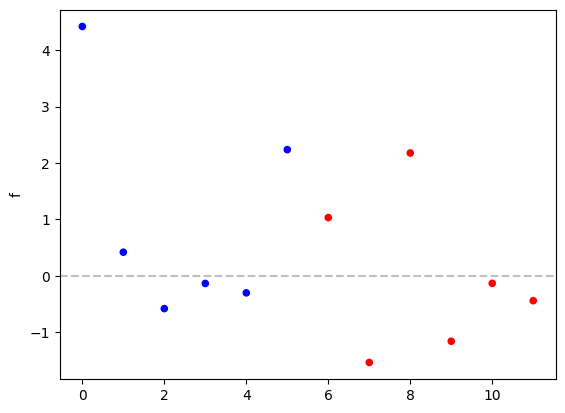

DWave cutoff
Kappa score =  0.16666666666666663
Accuracy score =  0.5833333333333334
AUROC =  0.6666666666666667
AUPRC =  0.6717592592592592


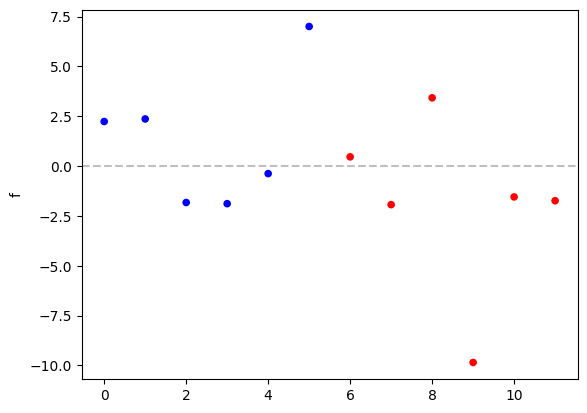

DWave cutoff
Kappa score =  0.16666666666666663
Accuracy score =  0.5833333333333334
AUROC =  0.5555555555555556
AUPRC =  0.6032587782587782


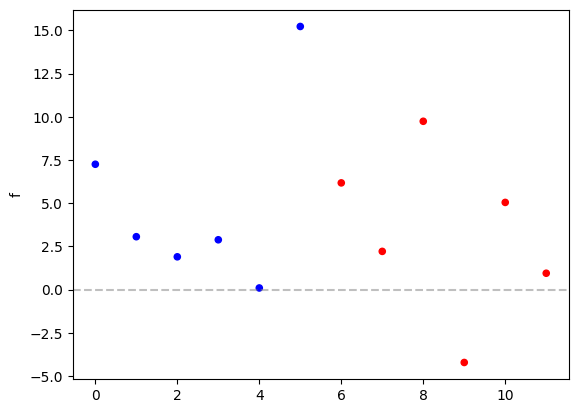

In [17]:
print_measures(fs[0], test_vectors, test_labels, 'SA')
plot_compounds(test_vectors, test_labels, fs[0])
# print_measures(gs[0], test_vectors, test_labels, 'Clique')
# plot_compounds(test_vectors, test_labels, gs[0])
# print_measures(hs[0], test_vectors, test_labels, 'DWave hybrid')
# plot_compounds(test_vectors, test_labels, hs[0])
print_measures(ks[0], test_vectors, test_labels, 'DWave cutoff')
plot_compounds(test_vectors, test_labels, ks[0])